In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import glob # helps with building file lists
import matplotlib.cm as cm  # Import the colormap module
from matplotlib.colors import LogNorm  # Import LogNorm for logarithmic scaling
# make figures interactive:
%matplotlib notebook 


# simple read
def read_raw_image(fits_file,get_header=0):
    # returns an index and the fluxes
    # Open the FITS file
    hdulist = fits.open(fits_file)
    header = hdulist[0].header
    # Assuming the spectrum data is in the first extension (HDU index 0)
    data = hdulist[0].data
#    xaxis= list(range(len(data)))
    if(get_header==0):
        return data
    if(get_header==1):
        return data,header

# simple write
def write_fits_image(target_file,data,header=[]):
    if(header==[]):
        hdu=fits.hdu.hdulist.PrimaryHDU(data)
    else:
        hdu=fits.hdu.hdulist.PrimaryHDU(data,header)
    hdul = fits.hdu.HDUList([hdu])
    hdul.writeto(target_file,overwrite=True)
    print('wrote ',target_file)
    
# print header of fits file
def print_header(file,keywords_list = ['OBJECT', 'FLTRNM', 'TM-EXPOS'],l=0):
    fits_file = fits.open(file)
    header = fits_file[0].header
    # print ALL:
    if(l==1):
        print(repr(header))
    else:
        result=''
        for keyword in keywords_list:
            if keyword in header:
#                print(header[keyword])
#                print(type(str(header[keyword])))
                result=result+' '+str(header[keyword])
            else:
                print(f'{keyword:8s} = Not found in header')
        print(result)
        
def get_stats(file):
    # returns 
    # filename, number of pixels (nx*ny), mean, dispersion (sigma), min, max
    data=read_raw_image(file)
    nx,ny=np.shape(data)
    return [file,nx*ny,np.average(data),np.std(data),np.min(data),np.max(data)]

def get_scaling(data):
    # useful to set vmin,vmax in plt.imshow
    vmin=np.average(data)-2.*np.std(data)
    vmax=np.average(data)+2.*np.std(data)
    return vmin,vmax    

def plot_image(data):
    plt.figure(figsize=(7,7))
    vmin,vmax=get_scaling(data)
    plt.imshow(data,origin='lower',aspect='auto',vmin=vmin,vmax=vmax)
    plt.show()

<IPython.core.display.Javascript object>


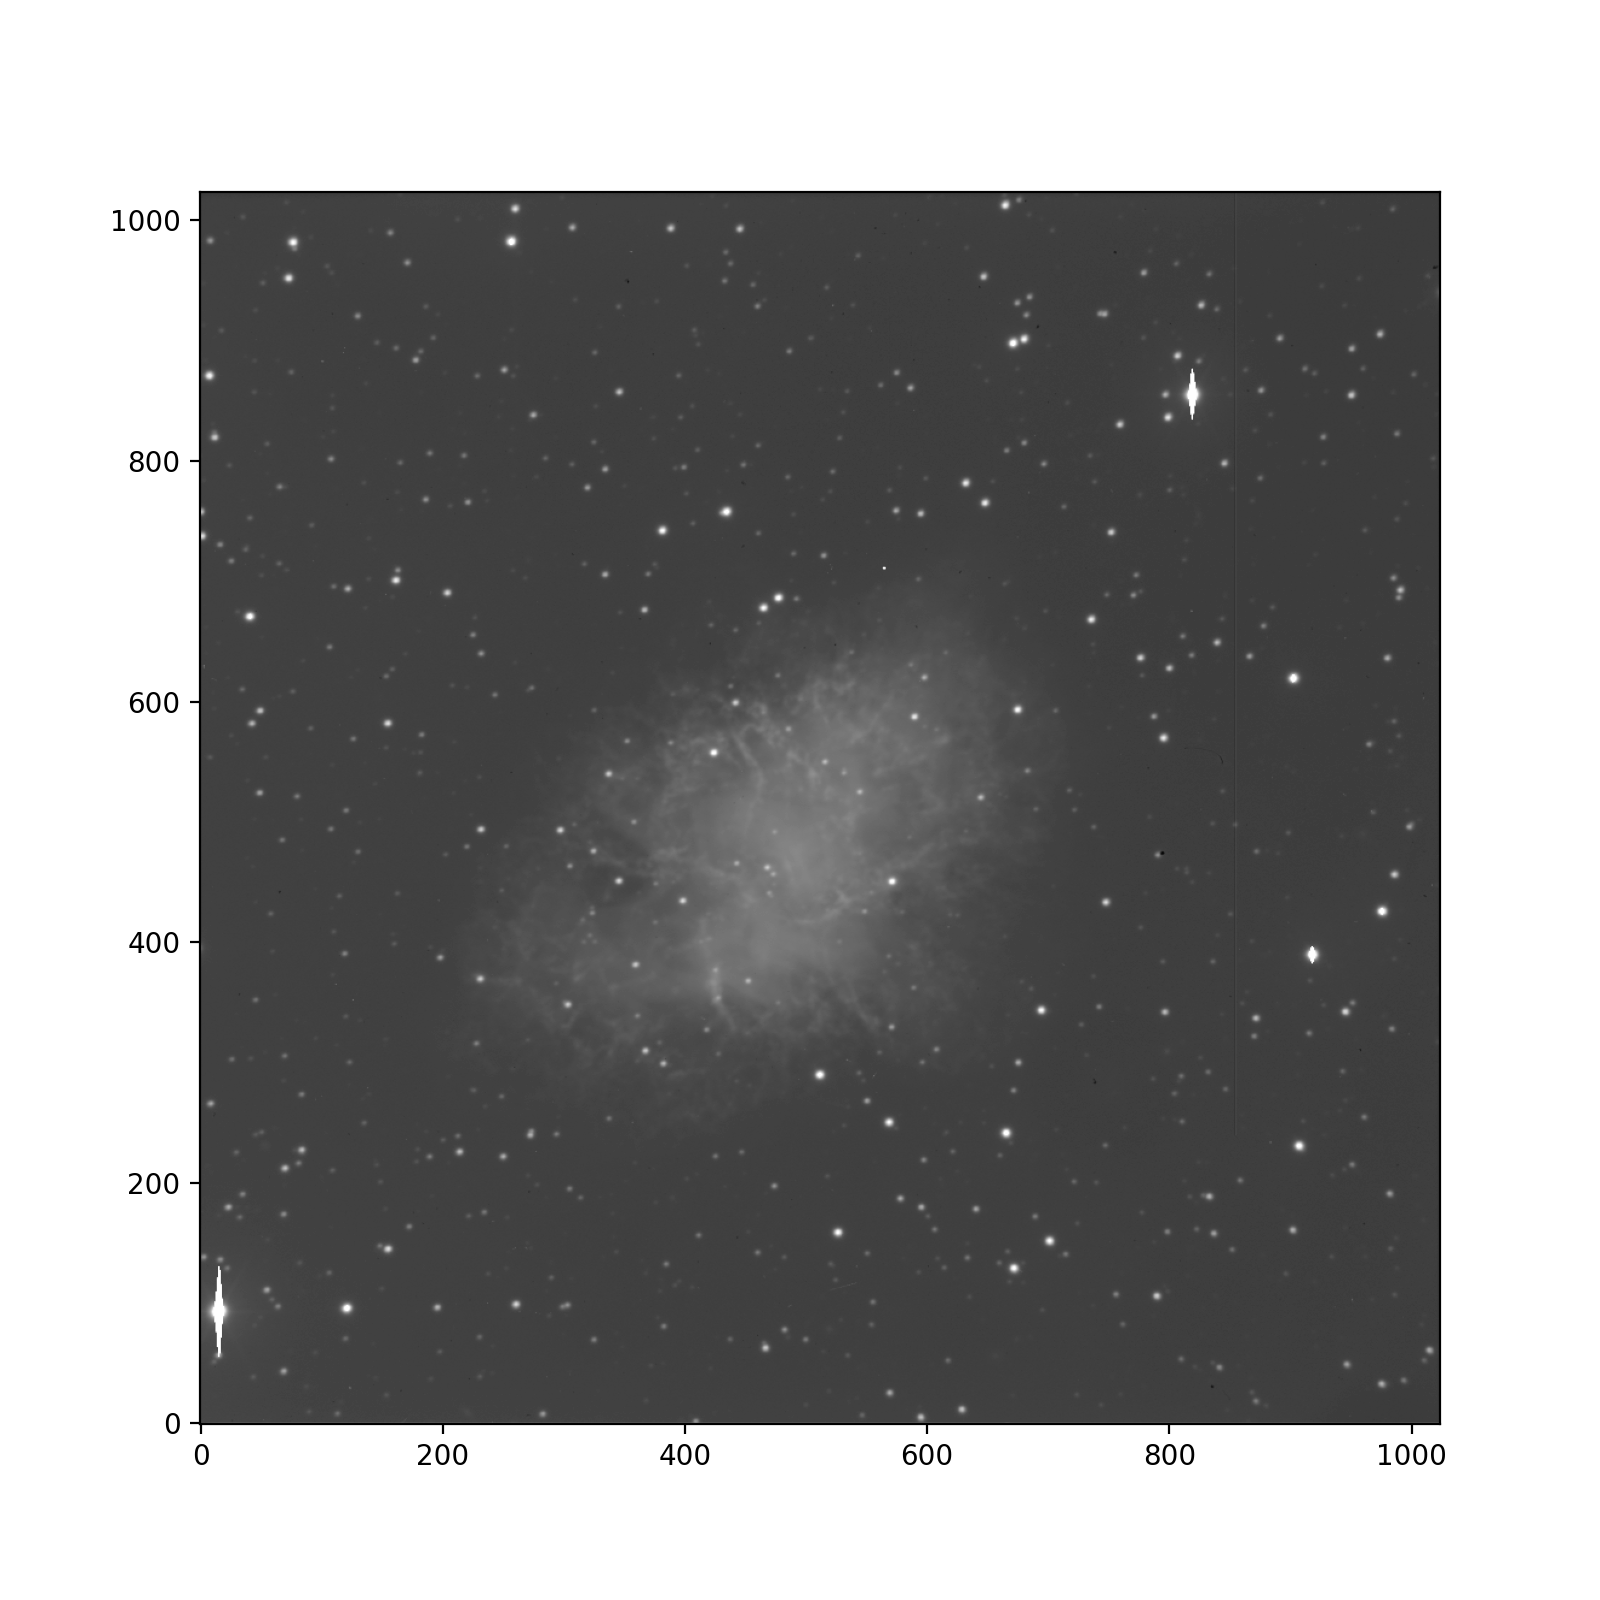

In [2]:
# first lets look at something pretty just to get the hang of how to display fits images in python
files=glob.glob('../../data/photo/M1/p*f1.fits')
data=read_raw_image(files[1])
plt.figure(figsize=(8,8))
# experiment with different scalings:
# linear
#plt.imshow(data,cmap=cm.gray,norm=None,origin='lower',aspect='auto')
# log
plt.imshow(data,cmap=cm.gray,norm=LogNorm(),origin='lower',aspect='auto')
# the origin='lower' option is to have the right orientation.
# it may be different with the most recent camera settings. TBD
plt.show()
# Noice

<IPython.core.display.Javascript object>


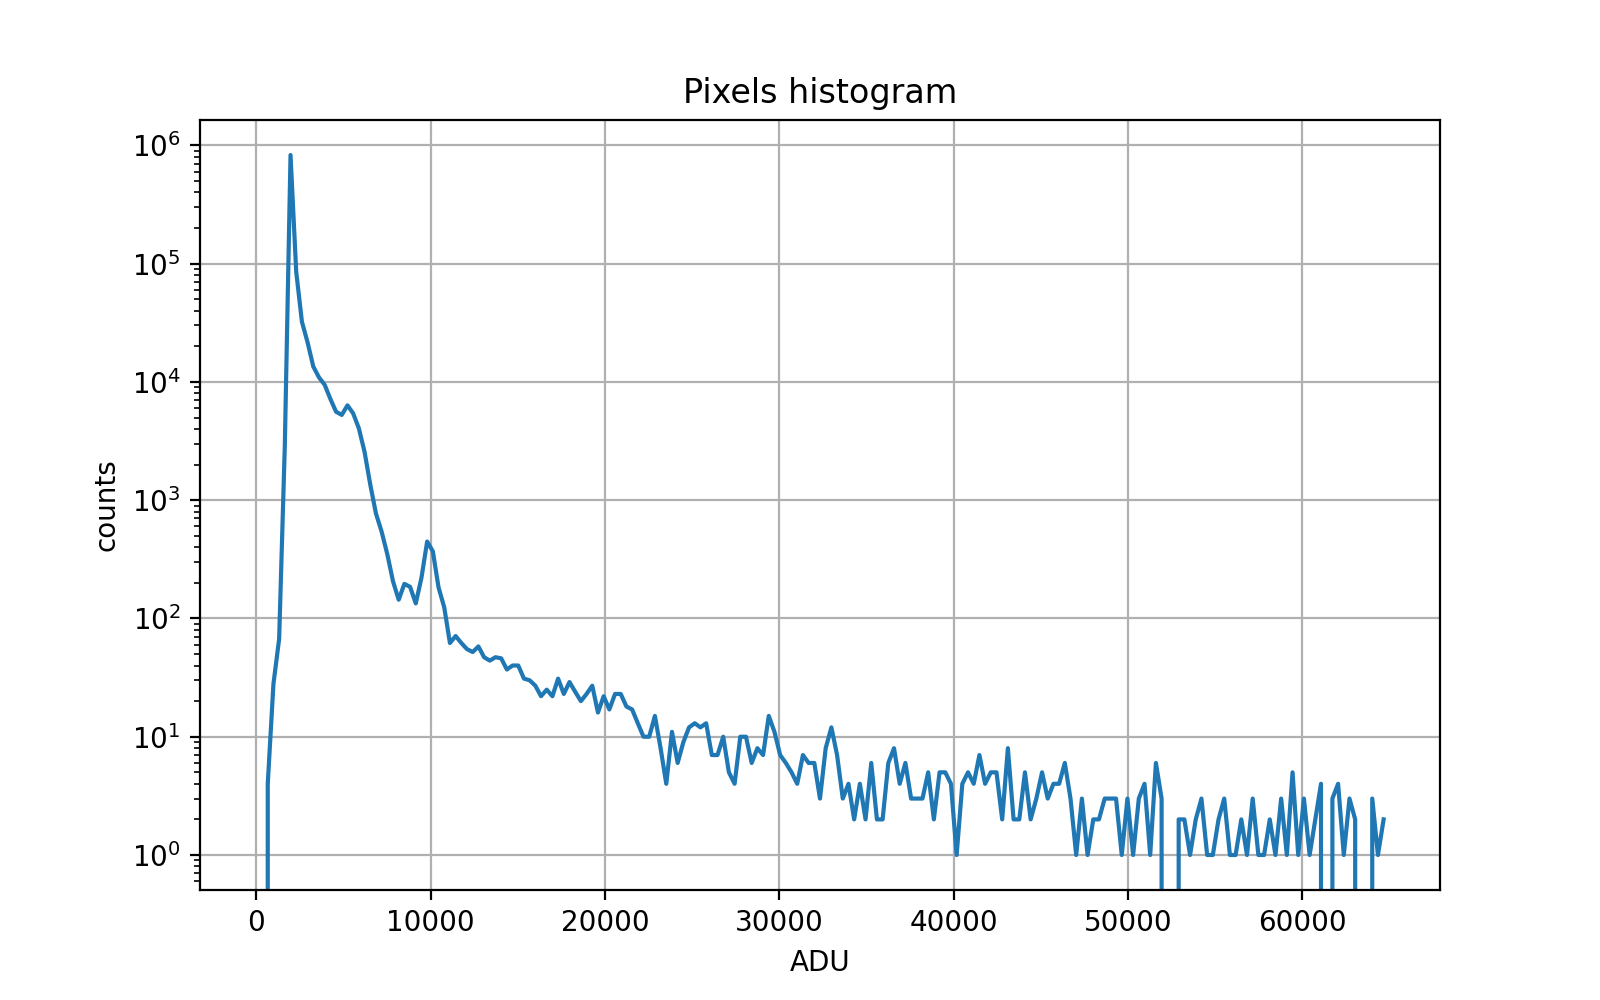

In [3]:
# Why is this? 
# lets have a look at the dynamics of the image!
bins=np.linspace(0.,65000.,200)
plt.figure(figsize=(8,5))
h,bins=np.histogram(data.flatten(),bins)
plt.plot(bins[:-1],h)
plt.yscale('log')
#plt.xscale('log')
plt.title('Pixels histogram')
plt.xlabel('ADU')
plt.ylabel('counts')
plt.grid(True)
plt.show()
# discuss the different regimes in the hitogram: 
# 1 - what is the large population of darkest pixels?
# 2 - what is the small population of brightest pixels?
# 3 - Where in this plot lives the nebulosity of interest?

In [4]:
# HEADERS! Getting information about the exposures is a vital skill!
# have a look at the header of the files for M1
files=glob.glob('../../data/photo/M1/p*f1.fits')
for file in files:
    print(file)
    print_header(file,keywords_list=['OBJECT'],l=0) # NOTE: relevant keyword to print may change depending on camera software setup


../../data/photo/M1/p43952f1.fits
 Messier1 / B Cousins /  1200.18  s
../../data/photo/M1/p43950f1.fits
 Messier1 / R Cousins /  600.17  s
../../data/photo/M1/p43946f1.fits
 Messier1 / R Cousins /  30.16  s
../../data/photo/M1/p43954f1.fits
 Messier1 / O3 ohp 5007 /  1200.18  s
../../data/photo/M1/p43948f1.fits
 Messier1 / R Cousins /  5.17  s
../../data/photo/M1/p43953f1.fits
 Messier1 / H Alpha ohp 6565 /  1200.18  s
../../data/photo/M1/p43951f1.fits
 Messier1 / V Cousins /  600.18  s
../../data/photo/M1/p43947f1.fits
 Messier1 / V Cousins /  60.17  s
../../data/photo/M1/p43949f1.fits
 Messier1 / R Cousins /  60.17  s


<IPython.core.display.Javascript object>


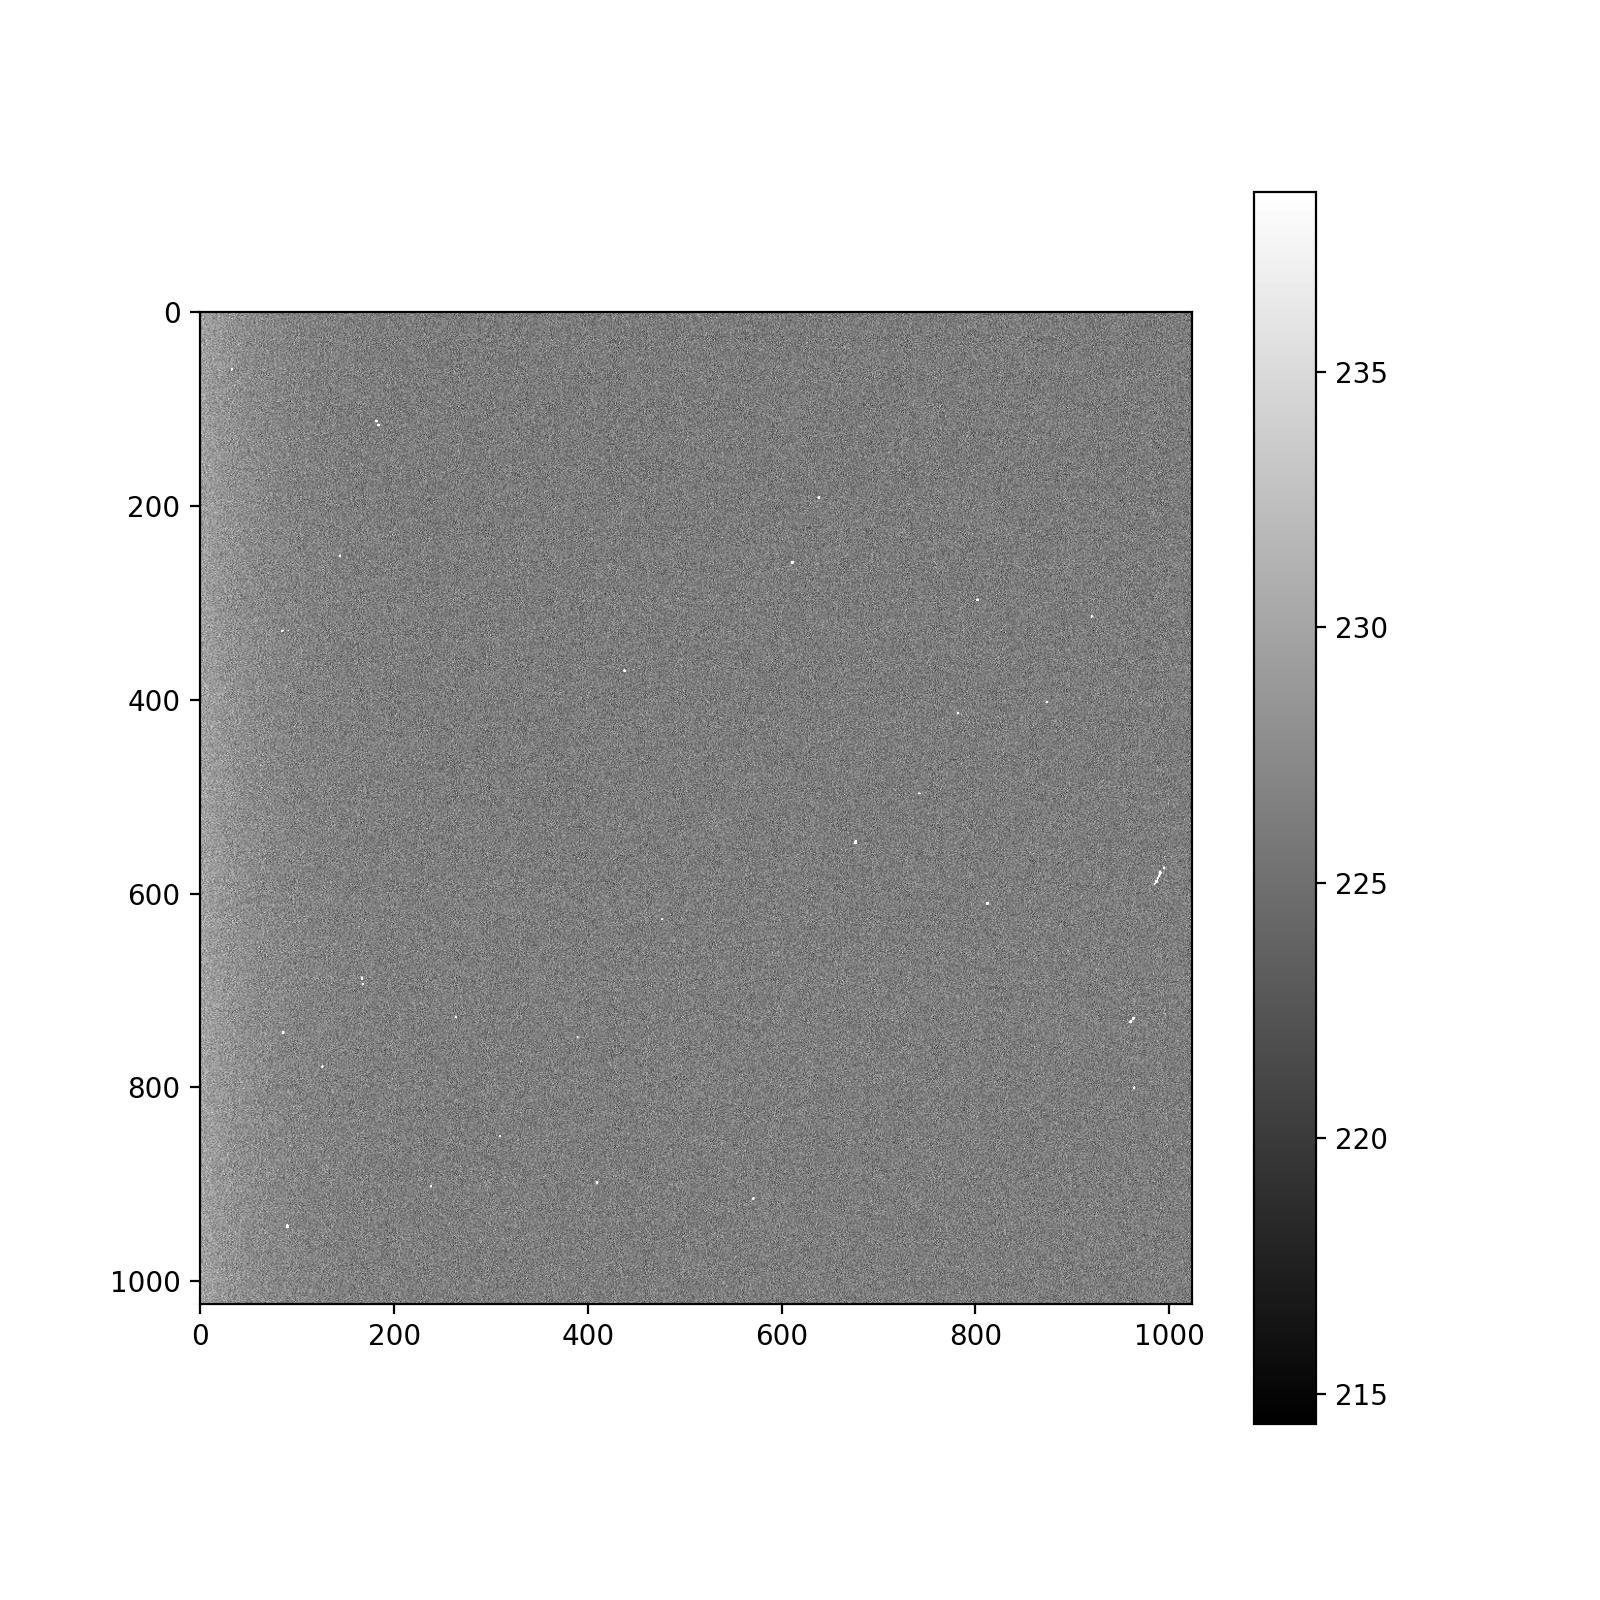

In [5]:
# Now let's start a proper image reduction.
# We will need the master bias and the master flat first.
# Let's make a bias
# where is the data?
files=glob.glob('../../data/photo/offsets/p*.fits')
data=read_raw_image(files[4])
# what does it look like?
plt.figure(figsize=(8,8))
# setup the cuts of the image
vmin,vmax=get_scaling(data)
plt.imshow(data,cmap=cm.gray,vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()

# What are all these white dots? do they appear in all images?

In [6]:
# OK let's try to make a master_bias, that requires medianning the 5 offset files
# first lets get some stats for the images:
files=glob.glob('../../data/photo/offsets/p*.fits')

print('filename,','Npix','avg,','rms,','min,','max')
for file in files:
    stats=get_stats(file)
    print(stats)
    
# whats' strange with these numbers?
# Do the stats of the pixels follow a classical gaussian distribution law?

filename, Npix avg, rms, min, max
['../../data/photo/offsets/p43958f1.fits', 1048576, 226.02331447601318, 5.395226593262076, 215, 3415]
['../../data/photo/offsets/p43956f1.fits', 1048576, 226.1780023574829, 4.110583114048485, 216, 1313]
['../../data/photo/offsets/p43959f1.fits', 1048576, 225.44656372070312, 3.736543015967175, 215, 1576]
['../../data/photo/offsets/p43955f1.fits', 1048576, 226.10054969787598, 5.538745576701716, 216, 2976]
['../../data/photo/offsets/p43957f1.fits', 1048576, 226.46543502807617, 6.028690662978478, 216, 3823]


In [7]:
# NOW compute the median of the 5 bias and store that into master_bias
files=glob.glob('../../data/photo/offsets/p*.fits')
nfiles=len(files)
data,header_ori=read_raw_image(files[0],get_header=1)
nx,ny=np.shape(data)
datastore=np.full((nx,ny,nfiles),0.)
# store individual images into an array
for i in range(nfiles):
    datastore[:,:,i]=read_raw_image(files[i])
# compute median of nfiles images
result=np.median(datastore,axis=2)
target_file='../../masters/photo/bias/master_bias.fits'
# update the OBJECT field of header
header=header_ori
header['OBJECT']='MASTER_BIAS'
# write to file
write_fits_image(target_file,result,header)


wrote  ../../masters/photo/bias/master_bias.fits


MASTER_BIAS
['./masters/photo/bias/master_bias.fits', 226.03228855133057, 1.3249962452232857, 220.0, 236.0]
individual biases
['../data/photo/offsets/p43958f1.fits', 226.02331447601318, 5.395226593262076, 215, 3415]
['../data/photo/offsets/p43956f1.fits', 226.1780023574829, 4.110583114048485, 216, 1313]
['../data/photo/offsets/p43959f1.fits', 225.44656372070312, 3.736543015967175, 215, 1576]
['../data/photo/offsets/p43955f1.fits', 226.10054969787598, 5.538745576701716, 216, 2976]
['../data/photo/offsets/p43957f1.fits', 226.46543502807617, 6.028690662978478, 216, 3823]


<IPython.core.display.Javascript object>


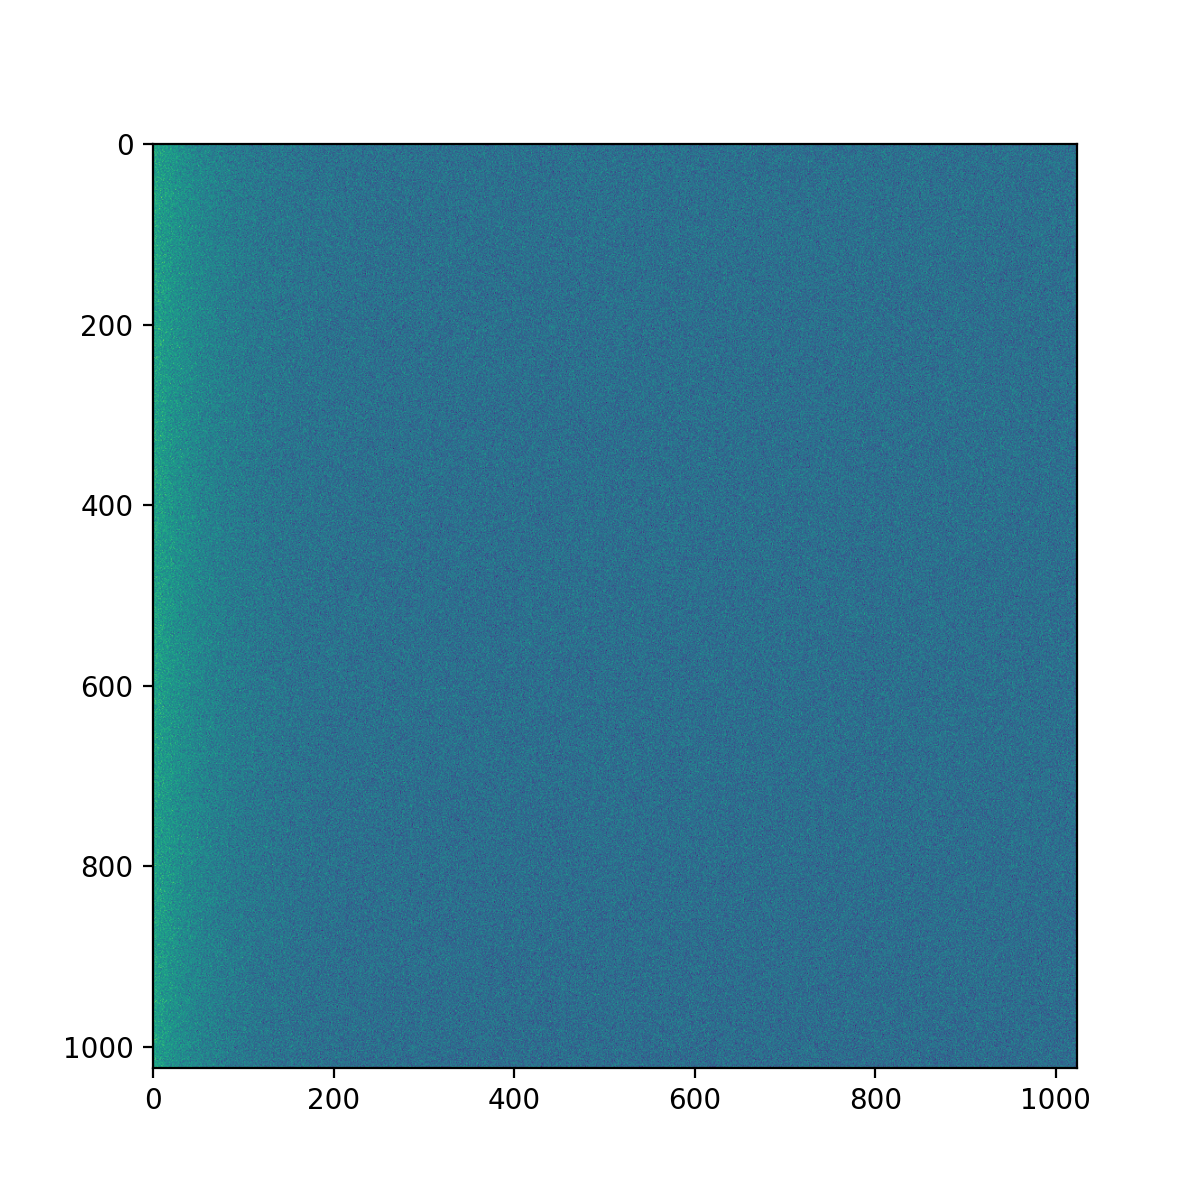

In [185]:
# Whats the new stats? Any improvement?
master_bias_file='./masters/photo/bias/master_bias.fits'
master_bias,header1=read_raw_image(master_bias_file,get_header=1)
print('MASTER_BIAS')
print(get_stats(master_bias_file))
print('individual biases')
for file in files:
    print(get_stats(file))

# yay stats of master_bias look much better!!
    
    
#How does it look?
plt.figure(figsize=(6,6))
plt.imshow(master_bias)
plt.show()


<IPython.core.display.Javascript object>


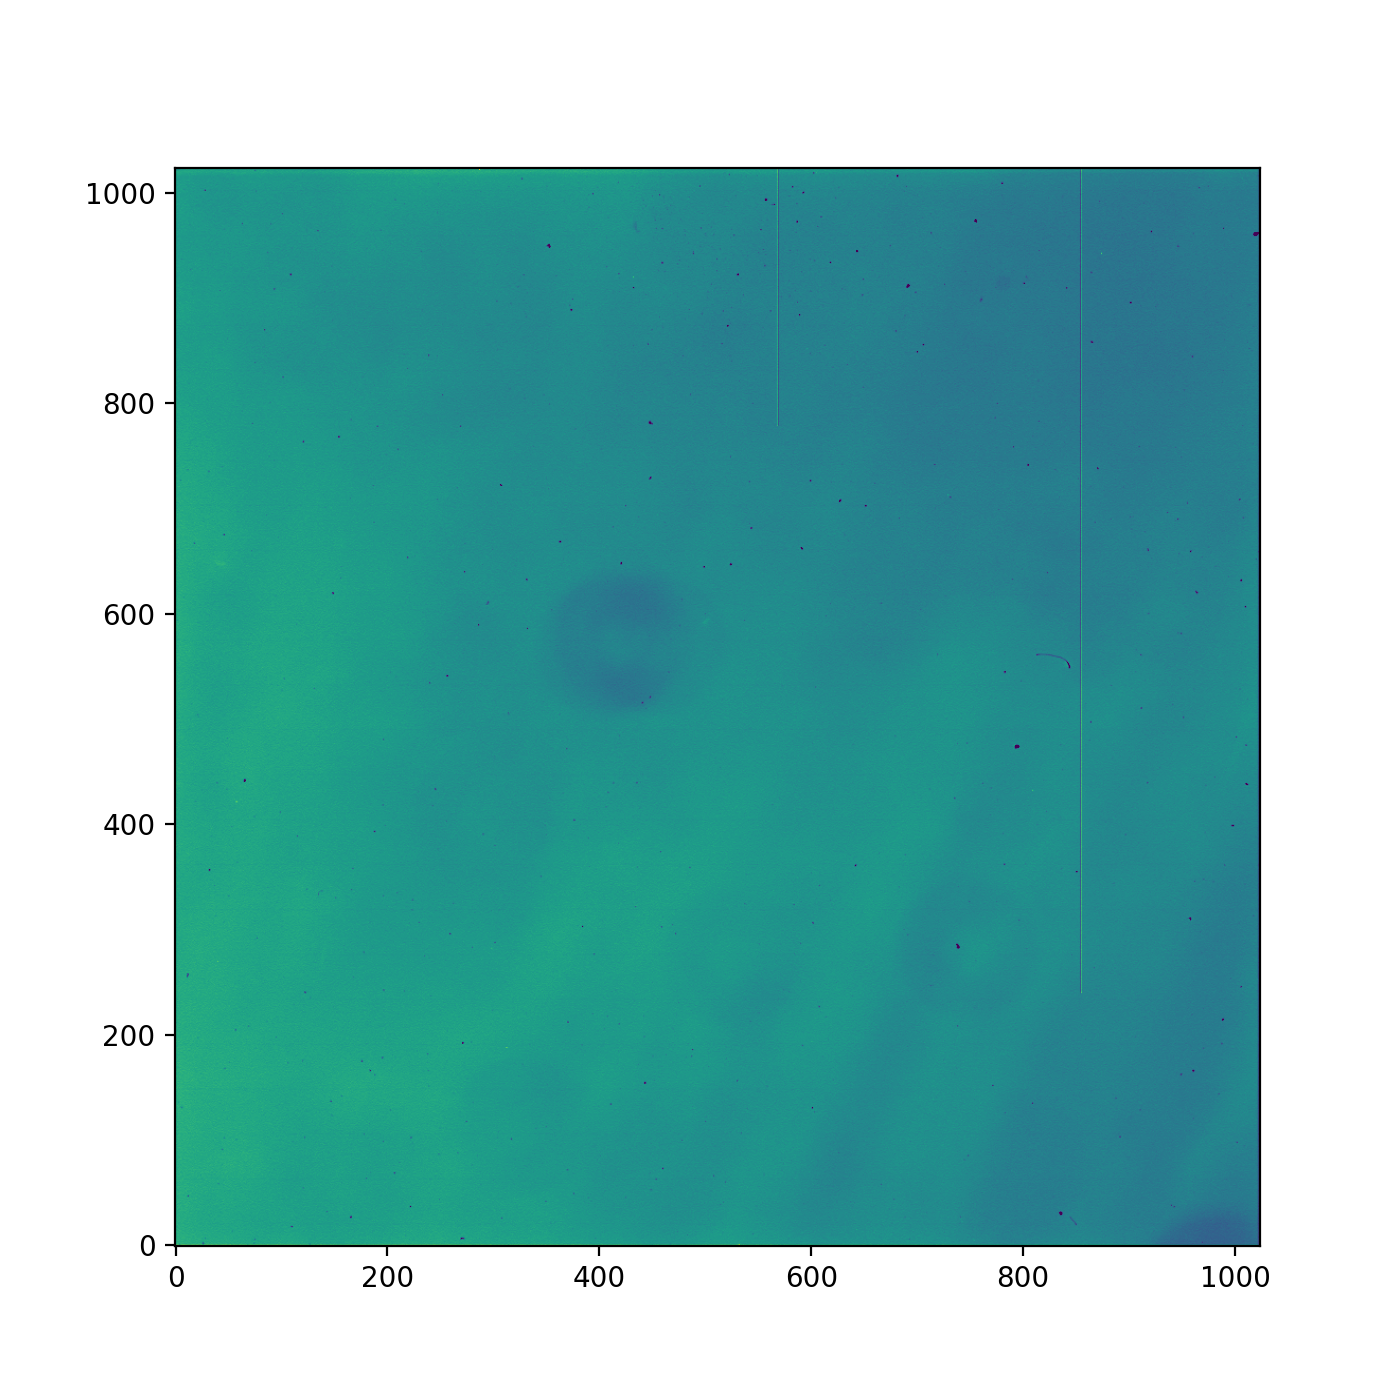

In [204]:
# Now lets make a flat!
files=glob.glob('../data/photo/flats/B/p*.fits')
nfiles=len(files)
# what does it look like?
data=read_raw_image(files[0])
plot_image(data)
# discuss the various structures we can see


In [205]:
# check the stats of the flats:
files=glob.glob('../data/photo/flats/B/p*.fits')
for file in files:
    print(get_stats(file))

['../data/photo/flats/B/p43933f1.fits', 1048576, 13196.5179977417, 1638.4209188126415, 2335, 65535]
['../data/photo/flats/B/p43937f1.fits', 1048576, 11515.656428337097, 1444.4436680076742, 2026, 59780]
['../data/photo/flats/B/p43935f1.fits', 1048576, 11959.858138084412, 1500.175532746047, 2149, 62105]
['../data/photo/flats/B/p43939f1.fits', 1048576, 11049.631291389465, 1389.4026678988967, 2012, 65535]
['../data/photo/flats/B/p43941f1.fits', 1048576, 10542.076983451843, 1320.3234805042289, 1851, 54500]


<IPython.core.display.Javascript object>


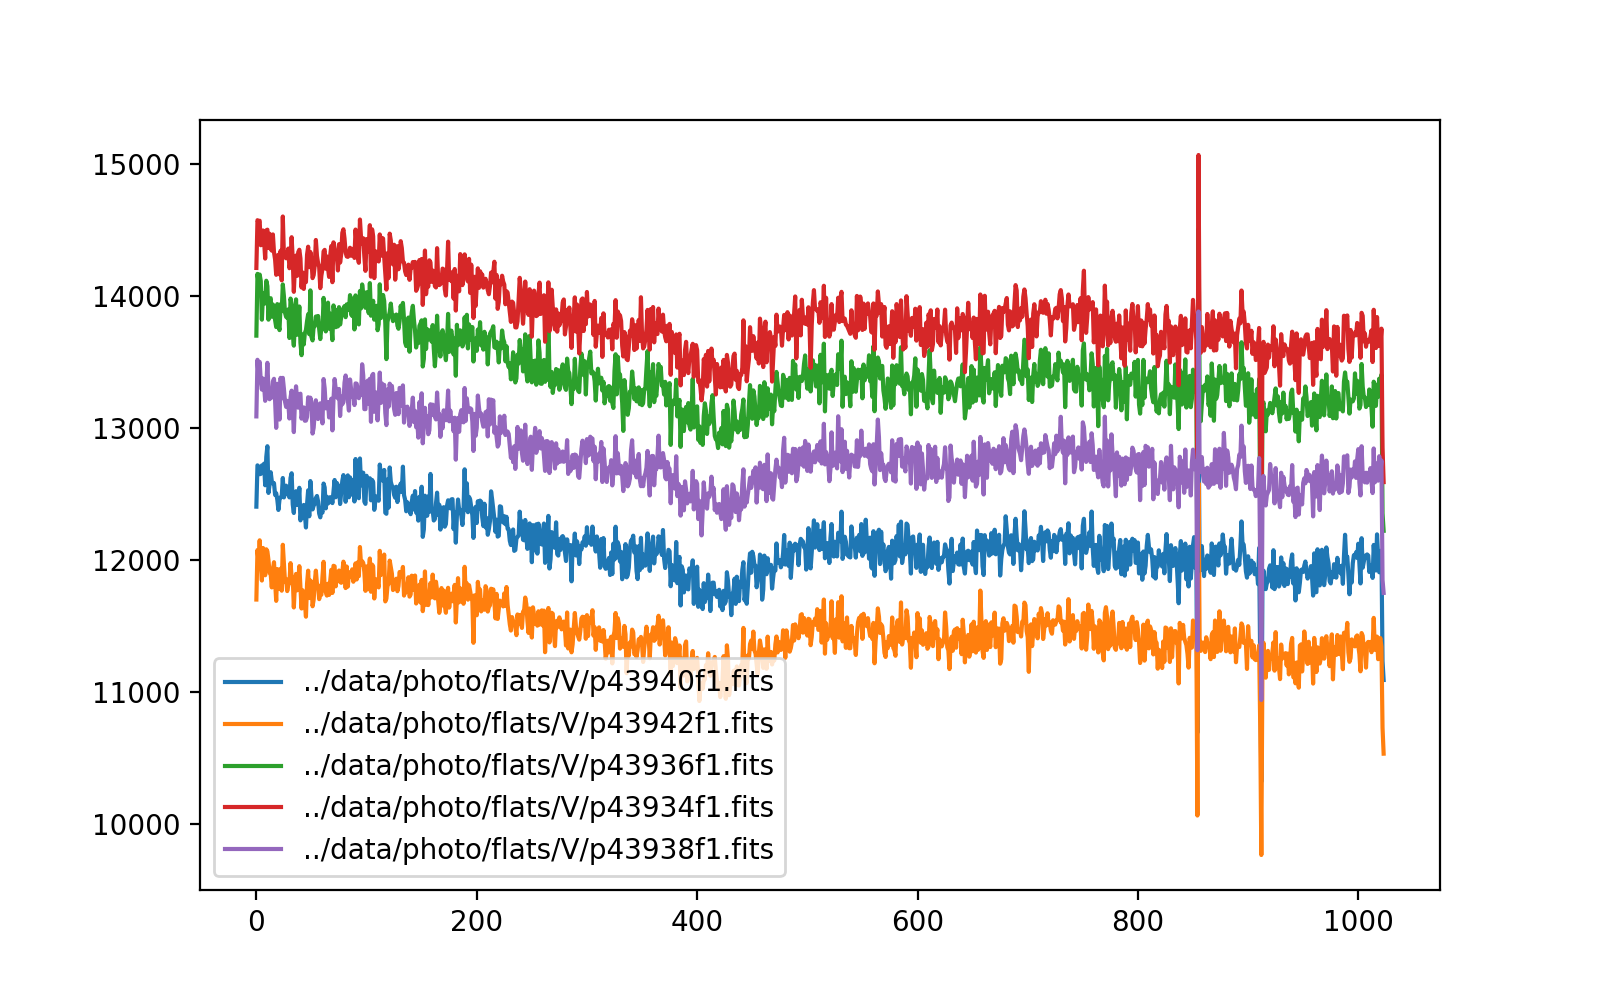

In [221]:
# plot the central line of each flat:
files=glob.glob('../data/photo/flats/V/p*.fits')
#files=glob.glob('../data/photo/offsets/p*.fits')
plt.figure(figsize=(8,5))
iline=511
for file in files:
    data=read_raw_image(file)
    plt.plot(data[iline,:],label=file)
plt.legend()
plt.show()

# what do you notice?

In [225]:
# Remove the master_bias from each flat, then compute the normalized flats, where each flat is divided by its median:
files=glob.glob('../data/photo/flats/V/p*.fits')
for file in files:
    data,header=read_raw_image(file,get_header=1)
    print(np.median(data))
    bias=read_raw_image('./masters/photo/bias/master_bias.fits')
    data=data-bias # Bias subtraction!
    data=data/np.median(data)
    newfile=file+'.norm'
    write_fits_image(newfile,data,header)

12064.0
wrote  ../data/photo/flats/V/p43940f1.fits.norm
11428.0
wrote  ../data/photo/flats/V/p43942f1.fits.norm
13336.0
wrote  ../data/photo/flats/V/p43936f1.fits.norm
13777.0
wrote  ../data/photo/flats/V/p43934f1.fits.norm
12740.0
wrote  ../data/photo/flats/V/p43938f1.fits.norm


<IPython.core.display.Javascript object>


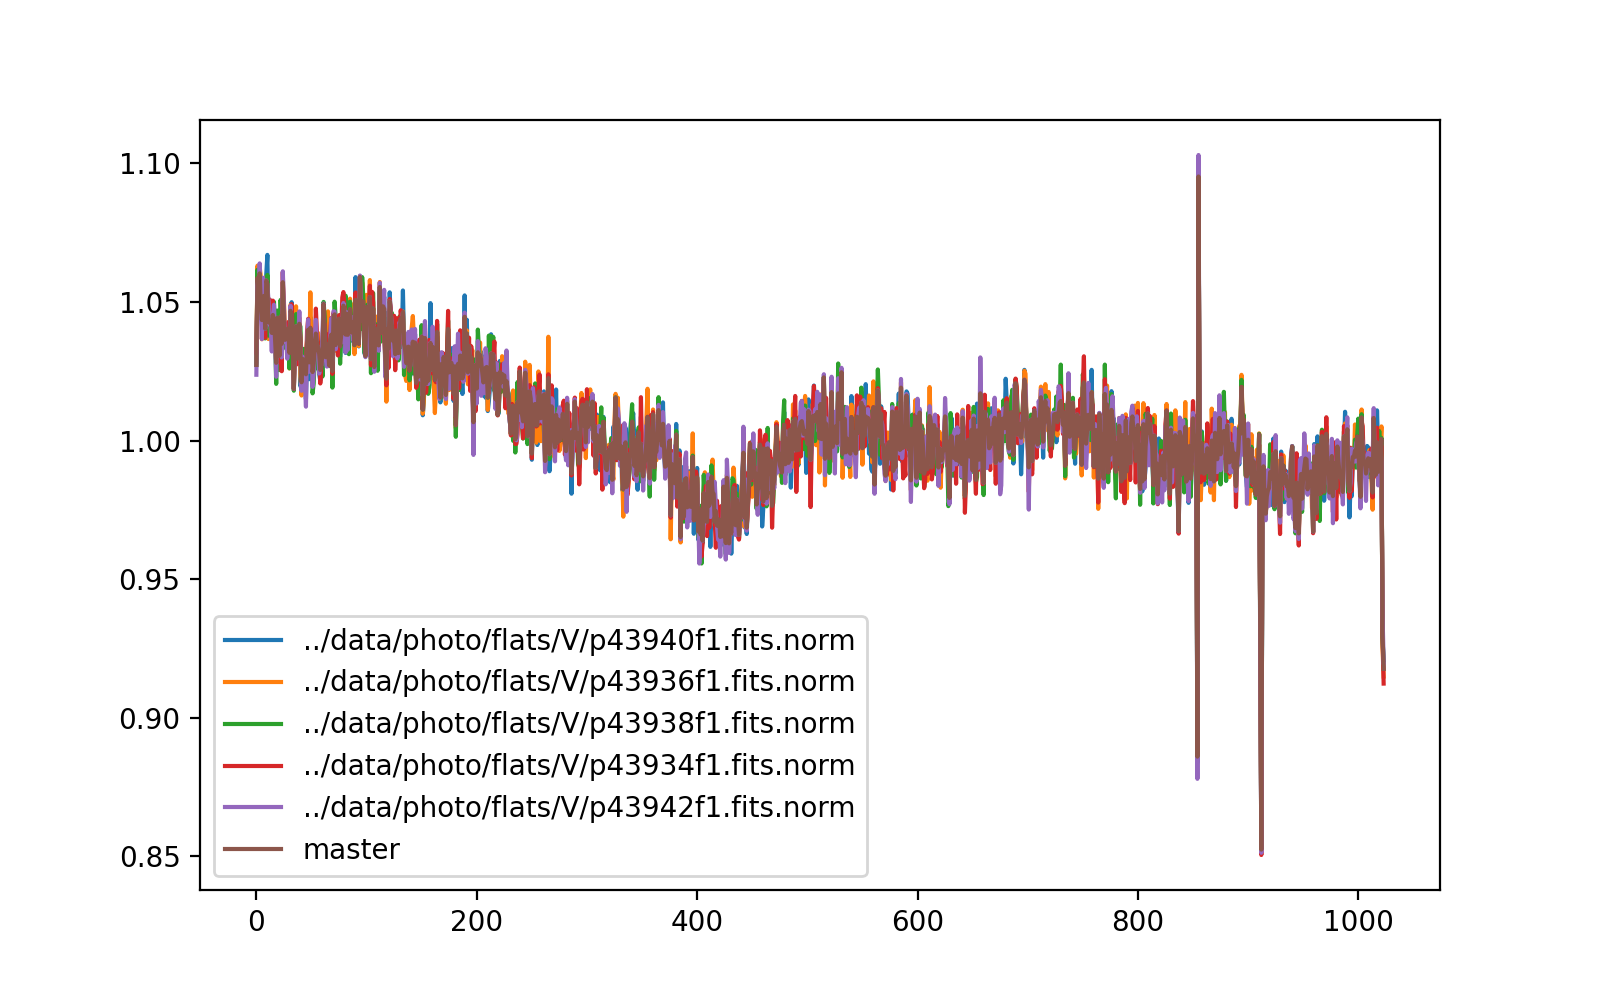

wrote  ./masters/photo/flats/master_flat_V.fits


In [226]:
# now plot these normalized flats:
# plot the central line of each flat:
files=glob.glob('../data/photo/flats/V/p*.fits.norm')
plt.figure(figsize=(8,5))
iline=511
for file in files:
    data=read_raw_image(file)
    plt.plot(data[iline,:],label=file)
    
    
# then median the normalized flats to get the master_flat in the considered filter
nfiles=len(files)
data,header_ori=read_raw_image(files[0],get_header=1)
nx,ny=np.shape(data)
datastore=np.full((nx,ny,nfiles),0.)
# store individual images into an array
for i in range(nfiles):
    datastore[:,:,i]=read_raw_image(files[i])
# compute median of nfiles images
result=np.median(datastore,axis=2)
target_file='./masters/photo/flats/master_flat_V.fits'
# update the OBJECT field of header
header=header_ori
header['OBJECT']='MASTER_FLAT'
# write to file
write_fits_image(target_file,result,header)

plt.plot(result[iline,:],label='master')
plt.legend()
plt.show()

In [244]:
# Now reduce the observed images:
# 1=> subtract bias
# 2=> divide by flat WITH THE CORRESPONDING FILTER!!
files=glob.glob('../data/photo/M1/p439*.fits')
filter_target='V Cousins'
nfiles=len(files)
for file in files:
    data,header=read_raw_image(file,get_header=1)
    filter_obs=header['FLTRNM']
    if(filter_obs.find(filter_target)>=0): # this checks that the filters match
        print('reducing ',file, filter_obs)
        bias=read_raw_image('./masters/photo/bias/master_bias.fits')
        flat=read_raw_image('./masters/photo/flats/master_flat_V.fits')
        # THE IMPORTANT PART!!!
        reduced=(data-bias)/flat
        reduced_file=file+'.reduced'
        write_fits_image(reduced_file,reduced,header)

# do this for each filter or automatize

reducing  ../data/photo/M1/p43951f1.fits                     V Cousins
wrote  ../data/photo/M1/p43951f1.fits.reduced
reducing  ../data/photo/M1/p43947f1.fits                     V Cousins
wrote  ../data/photo/M1/p43947f1.fits.reduced


In [ ]:
# Now redo the steps for the Halpha, OIII and B filters of M1
# => generate master_flat for each filter
# => reduce all Halpha, OIII and B images of M1 (i.e. subtract master_bias, divide by master_flat)